### Explore how good feature selection affect RMSE of log(price)

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import category_encoders as ce
import pandas as pd
import subprocess
import pprint as pp
import warnings

%matplotlib inline
PATH='../data/'

# submission
COMPETITION = 'house-prices-advanced-regression-techniques'
def post_kaggle(path, message):
    command = f'kaggle competitions submit -c {COMPETITION} -f {path} -m "{message}"'
    bytes_output = subprocess.check_output(command, shell=True)
    pp.pprint(str(bytes_output, encoding='UTF-8'))
    
def get_X(df):
    X = df[features_selected]
    # one-hot encoder categorical features
    features_cat = ['SaleCondition', 'Neighborhood']
    dummies = pd.get_dummies(X[features_cat])
    X_dropped = X.drop(features_cat, axis=1)
    X = pd.concat([X_dropped, dummies], axis=1)
    return X

def get_X_logMSSubClass(df):
    X = df[features_selected]
    # one-hot encoder categorical features
    features_cat = ['SaleCondition', 'Neighborhood']
    dummies = pd.get_dummies(X[features_cat])
    X_dropped = X.drop(features_cat, axis=1)
    X = pd.concat([X_dropped, dummies], axis=1)
    return X

def run_cv(X_train, X_val, y_train, y_val):
    model = XGBRegressor()
    param_grid = {
        'n_estimators': [5, 7, 10, 12, 15, 25, 50],
        'learning_rate': [0.1, 0.4, 0.5, 0.6, 1],
        'max_depth': [3, 4, 5, 6, 7, 10],
    }
    searchcv = GridSearchCV(model, cv=4, param_grid=param_grid)
    searchcv.fit(X_train, y_train)
    model = searchcv.best_estimator_
    print(searchcv.best_params_)
    print(searchcv.best_score_)
    val_pred = model.predict(X_val)
    mse = mean_squared_error(np.log(y_val), np.log(val_pred))
    rmse = np.sqrt(mse)
    print("validation RMSE:", rmse)
    return model

def run_modeling():
    model = XGBRegressor()
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    mse = mean_squared_error(np.log(y_val), np.log(val_pred))
    rmse = np.sqrt(mse)
    print("validation RMSE:", rmse)
    return model

In [7]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

In [14]:
features_selected = ['SaleCondition', 'MSSubClass', 'Neighborhood', 'OverallQual',
                    'OverallCond', 'GrLivArea', 'BedroomAbvGr']

In [16]:
train[features_selected].isnull().sum()

SaleCondition    0
MSSubClass       0
Neighborhood     0
OverallQual      0
OverallCond      0
GrLivArea        0
BedroomAbvGr     0
dtype: int64

In [58]:
train.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

There is no missing values in the above features, so let's run a baseline XGBRegressor to see how well we do using only 7 features as above.

In [70]:
y = train['SalePrice']
X = get_X(train)
# train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

model = run_cv(X_train, X_val, y_train, y_val)

warnings.filterwarnings('ignore')
# one-hot encoding test dataframe
test_transformed = get_X(test)
test_transformed['SalePrice'] = model.predict(test_transformed)
test_transformed = pd.concat([test[['Id']], test_transformed['SalePrice']], axis=1)
df_submitting = test_transformed[['Id', 'SalePrice']]
path_output = './output.csv'
df_submitting.to_csv(path_output, index=False)
post_kaggle(path_output, 'feature selection, only 6, naive xgb')

(1022, 36) (1022,) (438, 36) (438,)


TypeError: run_cv() missing 4 required positional arguments: 'X_train', 'X_val', 'y_train', and 'y_val'

## Log transform of MSSubClass

See if taking log transformation of MSSubClass reduces error. Because MSSubClass has right-skewed distribution.

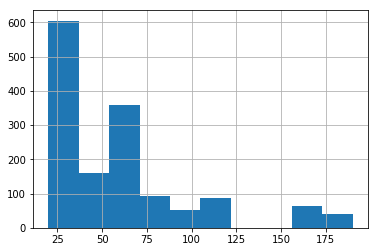

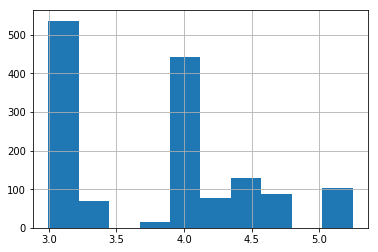

In [63]:
y = train['SalePrice']
X = get_X(train)
X['MSSubClass'].hist()
plt.show() 

X['MSSubClass'] = np.log(X['MSSubClass'])
X['MSSubClass'].hist()

Log transformation does not reduce the skewness. The reason might be that the original distribution is now a skewed normal distribution, it does not tail on the left. Anyway, let's try to fit a model on it any way to see if there is improvement.

In [67]:
warnings.filterwarnings('ignore')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
model = run_cv(X_train, X_val, y_train, y_val)

{'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 25}
0.8434218956296858
validation RMSE: 0.1517527730955055


In [68]:
test_transformed = get_X(test)
# log transform of feature MSSubClass of test data
test_transformed['MSSubClass'] = np.log(test_transformed['MSSubClass'])
test_transformed['SalePrice'] = model.predict(test_transformed)
test_transformed = pd.concat([test[['Id']], test_transformed['SalePrice']], axis=1)
df_submitting = test_transformed[['Id', 'SalePrice']]
path_output = './output.csv'
df_submitting.to_csv(path_output, index=False)
post_kaggle(path_output, 'feature selection, only 6, naive xgb')

'Successfully submitted to House Prices: Advanced Regression Techniques'


Public score improve a little, from 0.15953 reduced to 0.15895. The validation RMSE stays the same at 0.1517

## Loss - How do xgboost that I'm optimized for RMSE of log(price)
- what is the score xgboost calculating?
- is it aligned with my RMSE of log(SalePrice) score?

In [72]:
# pass eval_metric='rmse' to model.fit() function
y = train['SalePrice']
X = get_X(train)
X['MSSubClass'] = np.log(X['MSSubClass'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
model = XGBRegressor()
param_grid = {
    'n_estimators': [5, 7, 10, 12, 15, 25, 50],
    'learning_rate': [0.05, 0.1, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 10],
}
searchcv = GridSearchCV(model, cv=4, param_grid=param_grid)
searchcv.fit(X_train, y_train, eval_metric='rmse')
model = searchcv.best_estimator_
print(searchcv.best_params_)
print(searchcv.best_score_)
val_pred = model.predict(X_val)
mse = mean_squared_error(np.log(y_val), np.log(val_pred))
rmse = np.sqrt(mse)
print("validation RMSE:", rmse)
model.feature_importances_

{'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 25}
0.8434218956296858
validation RMSE: 0.1517527730955055


array([0.02579284, 0.4445752 , 0.01777592, 0.08542355, 0.01133616,
       0.01173441, 0.        , 0.01387568, 0.00173048, 0.0242124 ,
       0.05167069, 0.00578878, 0.        , 0.02224982, 0.00367089,
       0.02356117, 0.00506292, 0.00772393, 0.00582957, 0.0353227 ,
       0.01685827, 0.        , 0.00933245, 0.00869253, 0.        ,
       0.00785994, 0.01014003, 0.01811853, 0.06379423, 0.01374124,
       0.        , 0.00085013, 0.01277062, 0.01426163, 0.00938452,
       0.01685877], dtype=float32)

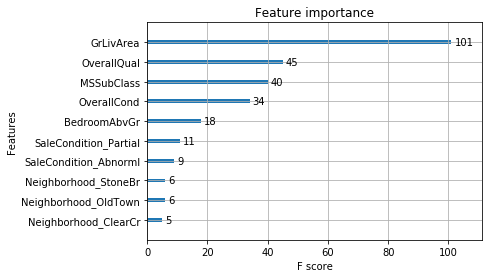

In [74]:
xgboost.plot_importance(model, max_num_features=10)

In [69]:
# list of cols having
cols_missing = ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
                'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 
                'PoolQC', 'Fence', 'MiscFeature']
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [7]:
train.dtypes[cols_missing]

LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
dtype: object

In [28]:
train.shape

(1460, 81)

In [16]:
train[cols_missing].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [27]:
test[cols_missing].isnull().sum()

LotFrontage      227
Alley           1352
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
Electrical         0
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
dtype: int64

In [47]:
def create_missing_df(df):
    cols_missing = df.columns[df.isnull().any()].tolist()
    series_missing_count = df[cols_missing].isnull().sum()
    series_missing_dtypes = df.dtypes[cols_missing]
    df_missing = pd.concat(
        [series_missing_count, series_missing_dtypes], 
        axis=1, 
        keys=['count', 'dtype'])
    return df_missing.sort_values(by=['count'], ascending=False)
    
train_missing = create_missing_df(train)
train_missing

,count,dtype
PoolQC,1453,object
MiscFeature,1406,object
Alley,1369,object
Fence,1179,object
FireplaceQu,690,object
LotFrontage,259,float64
GarageType,81,object
GarageYrBlt,81,float64
GarageFinish,81,object
GarageQual,81,object


In [44]:
cols_missing_test = test.columns[test.isnull().any()].tolist()
test_missing_count = test[cols_missing_test].isnull().sum()
test_missing_dtypes = test.dtypes[cols_missing_test]
test_missing = pd.concat(
    [test_missing_count, test_missing_dtypes], 
    axis=1, 
    keys=['count', 'dtype'])
test_missing.sort_values(by=['count'], ascending=False)

,count,dtype
PoolQC,1456,object
MiscFeature,1408,object
Alley,1352,object
Fence,1169,object
FireplaceQu,730,object
LotFrontage,227,float64
GarageCond,78,object
GarageYrBlt,78,float64
GarageQual,78,object
GarageFinish,78,object


In [68]:
print(train['GarageCond'].value_counts(dropna=False), end="\n\n")
print(train['GarageType'].value_counts(dropna=False), end="\n\n")

TA     1326
NaN      81
Fa       35
Gd        9
Po        7
Ex        2
Name: GarageCond, dtype: int64

Attchd     870
Detchd     387
BuiltIn     88
NaN         81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64



In [33]:
cols_test_not_train = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1', 
 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 
 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea', 'SaleType']

test.dtypes[cols_test_not_train]

MSZoning         object
Utilities        object
Exterior1st      object
Exterior2nd      object
BsmtFinSF1      float64
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
BsmtFullBath    float64
BsmtHalfBath    float64
KitchenQual      object
Functional       object
GarageCars      float64
GarageArea      float64
SaleType         object
dtype: object

# Imputing

In [1]:
import sklearn

In [3]:
sklearn.impute.SimpleImputer

AttributeError: module 'sklearn' has no attribute 'impute'

In [2]:
sklearn.__version__

'0.19.1'